# 3. Создание нейронной сети при помощи пакета `torch`. Dataset и Dataloader.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г. 

In [349]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [44]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [45]:
plt.style.use('science')
sns.set_theme()

plt.rcParams['figure.figsize'] = (8, 4)

## 1. Автоматическое дифференцирование в `torch`

1.1 Воспользовавшись классами `Neuron` и `MSELoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [46]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [47]:
def pretty_train_log(epoch: int, **kwargs) -> None:
    params = '\n\t'.join([f'{k} = {v}' for k, v in kwargs.items()])
    print(f'epoch {epoch:03} |' + '-' * 50 + f'\n\t{params}\n')

In [48]:
class Neuron:

    def __init__(self, in_features: int):
        self.in_features = in_features

        self.weights = torch.randn(self.in_features, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.sum(self.weights * inputs) + self.bias


class SELoss:

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return (y_pred - y_true) ** 2


In [49]:
torch.manual_seed(0)

neuron = Neuron(X.size(1))
se = SELoss()

lr = 0.1
epochs = 10
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        y_pred = neuron.forward(x)

        loss = se.forward(y_pred, y_true)
        loss.backward()

        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.bias.grad

        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()

neuron.weights, coef

(tensor([48.4987, 76.4411, 82.8207,  5.4316], requires_grad=True),
 array([48.49872363, 76.44109167, 82.82072306,  5.43161203]))

1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [126]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [127]:
class Linear:

    def __init__(self, in_features: int, out_features: int):
        self.in_features = in_features
        self.out_features = out_features

        self.weights = torch.randn(out_features, in_features, requires_grad=True)
        self.biases = torch.randn(out_features, requires_grad=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.matmul(inputs, self.weights.T) + self.biases


class MSELoss:

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return torch.mean((y_pred - y_true) ** 2)


class ReLU:

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.maximum(inputs, torch.tensor(0))

In [135]:
torch.manual_seed(0)

fc1 = Linear(X.size(1), 100)
relu = ReLU()
fc2 = Linear(100, y.size(1))
mse = MSELoss()

lr = 0.01
epochs = 1000

losses = torch.empty(epochs)
for epoch in range(epochs):
    y_pred = fc2.forward(relu.forward(fc1.forward(X)))

    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    with torch.no_grad():
        fc1.weights -= lr * fc1.weights.grad
        fc1.biases -= lr * fc1.biases.grad
        fc2.weights -= lr * fc2.weights.grad
        fc2.biases -= lr * fc2.biases.grad

    fc1.weights.grad.zero_()
    fc1.biases.grad.zero_()
    fc2.weights.grad.zero_()
    fc2.biases.grad.zero_()

predicts = fc2.forward(relu.forward(fc1.forward(X)))

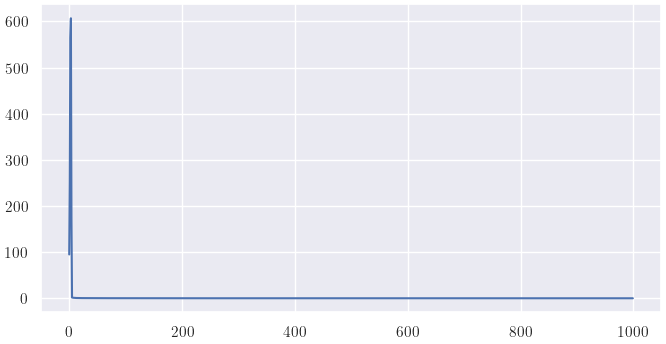

In [136]:
plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

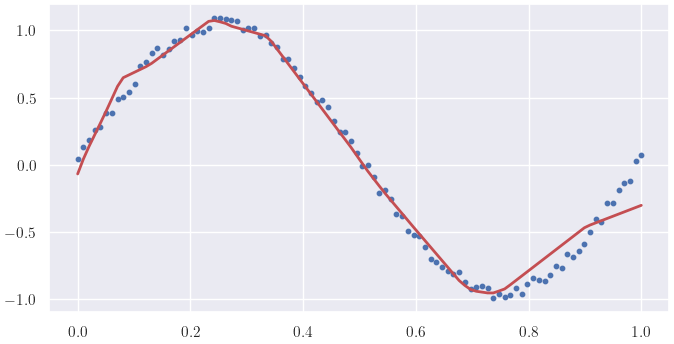

In [137]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

## 2. Алгоритмы оптимизации в `torch.optim`

2.1 Решить задачу 1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [140]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [141]:
torch.manual_seed(0)

neuron = Neuron(X.size(1))
se = SELoss()

lr = 0.1
optimizer = optim.SGD([neuron.weights, neuron.bias], lr=lr)

epochs = 10
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        optimizer.zero_grad()

        y_pred = neuron.forward(x)
        loss = se.forward(y_pred, y_true)
        loss.backward()

        optimizer.step()

neuron.weights, coef

(tensor([55.5688, 54.0985, 21.7544, 31.9758], requires_grad=True),
 array([55.5688475 , 54.09847046, 21.75440122, 31.97576001]))

2.2 Решить задачу 1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [143]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [145]:
torch.manual_seed(0)

fc1 = Linear(X.size(1), 100)
relu = ReLU()
fc2 = Linear(100, y.size(1))
mse = MSELoss()

lr = 0.01
optimizer = optim.Adam([fc1.weights, fc1.biases, fc2.weights, fc2.biases], lr=lr)

epochs = 1000
losses = torch.empty(epochs)
for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = fc2.forward(relu.forward(fc1.forward(X)))
    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    optimizer.step()

predicts = fc2.forward(relu.forward(fc1.forward(X)))

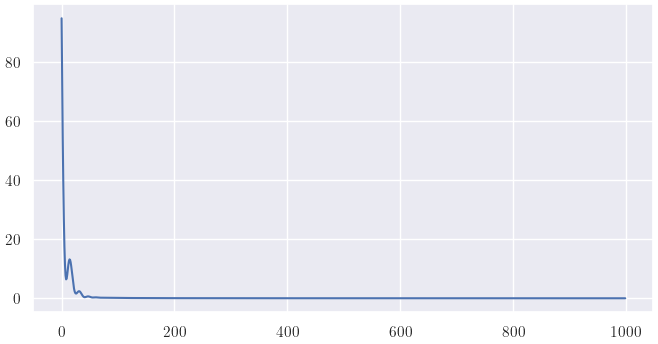

In [146]:
plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

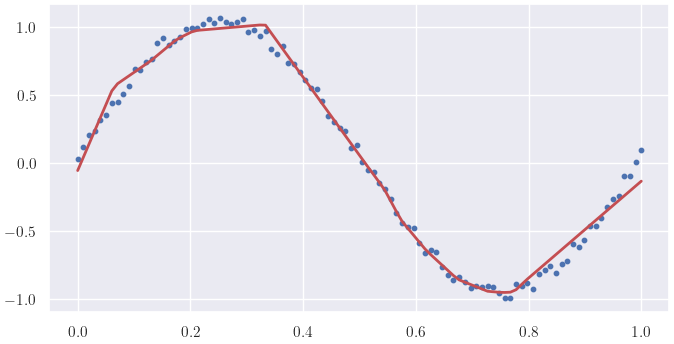

In [147]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

## 3. Построение сетей при помощи `torch.nn`

3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [161]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [172]:
class Net(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(Net, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc1 = nn.Linear(self.in_features, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, self.out_features)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.relu(self.fc1(inputs)))


In [182]:
torch.manual_seed(0)

net = Net(X.size(1), y.size(1))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [183]:
for epoch in range(1000):
    optimizer.zero_grad()

    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()

predicts = net(X)

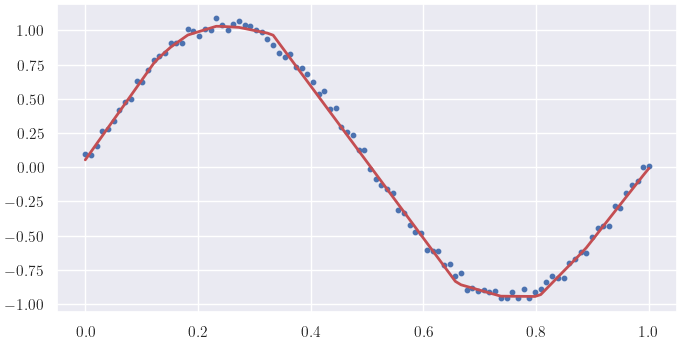

In [184]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [198]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [216]:
torch.manual_seed(0)

in_features = X.size(1)
out_features = y.size(1)

net = nn.Sequential(
    nn.Linear(in_features, 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, out_features),
)
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [217]:
for epoch in range(1000):
    optimizer.zero_grad()

    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()

predicts = net(X)

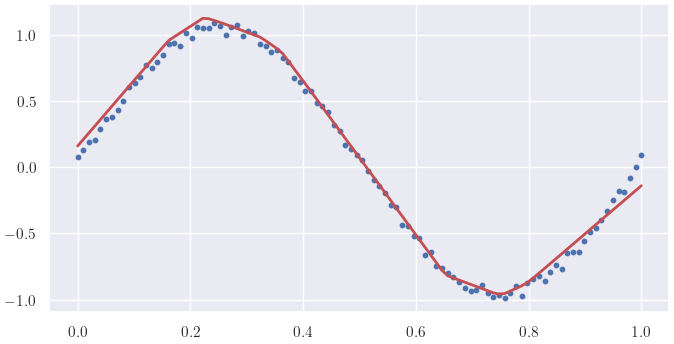

In [218]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

3.3 Решить задачу классификации. Датасет: Breast Cancer Wisconsin
1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [330]:
from sklearn import datasets

dataset = datasets.load_breast_cancer()

X = torch.from_numpy(dataset.data).to(torch.float32)
y = torch.from_numpy(dataset.target).to(torch.float32).view(-1, 1)

print(dataset.DESCR.split(':Summary Statistics:')[0].strip())

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [331]:
def accuracy_score(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    return torch.sum(y_pred == y_true) / y_pred.size(0)

In [337]:
torch.manual_seed(0)

net = nn.Sequential(
    nn.Linear(X.size(1), 50),
    nn.ReLU(),
    nn.Linear(50, y.size(1)),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

epochs = 1000
for epoch in range(epochs + 1):
    optimizer.zero_grad()

    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()

    if epoch % 200 == 0:
        accuracy = accuracy_score(y, y_pred.round())
        print(f"Epoch [{epoch:4}/{epochs}]{' ' * 6}loss = {loss:.5f}, accuracy = {accuracy:.5f}")

Epoch [   0/1000]      loss = 10.10273, accuracy = 0.37258
Epoch [ 200/1000]      loss = 0.17000, accuracy = 0.92970
Epoch [ 400/1000]      loss = 0.12417, accuracy = 0.95079
Epoch [ 600/1000]      loss = 0.09694, accuracy = 0.95782
Epoch [ 800/1000]      loss = 0.08035, accuracy = 0.96134
Epoch [1000/1000]      loss = 0.07004, accuracy = 0.97012


## 4. Datasets and dataloaders

4.1 Создать датасет, поставляющий данные из задачи 1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.1 (или 3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [437]:
class SinDataset(Dataset):

    def __init__(self):
        self.data = torch.linspace(0, 1, 100).view(-1, 1)
        self.target = torch.sin(2 * np.pi * self.data) + 0.1 * torch.rand(self.data.size())

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        return self.data[idx], self.target[idx]

In [438]:
sin_dataset = SinDataset()
sin_dataloader = DataLoader(sin_dataset, batch_size=10)

X, y = sin_dataset.data, sin_dataset.target

In [439]:
net = nn.Sequential(
    nn.Linear(X.size(1), 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, y.size(1)),
)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [440]:
steps = len(sin_dataloader)
epoch = 500
for epoch in range(epoch + 1):
    for i, (x_, y_) in enumerate(sin_dataloader):
        optimizer.zero_grad()

        y_pred = net(x_)
        loss = criterion(y_pred, y_)
        loss.backward()

        optimizer.step()

        if epoch % 100 == 0 and i % 5 == 0:
            print(f"Epoch [{epoch:4}/{epochs}], step [{i:2}/{steps}]{' ' * 6}loss = {loss:.5f}, batch_size = {x_.size(0)}")

Epoch [   0/1000], step [ 0/10]      loss = 0.07953, batch_size = 10
Epoch [   0/1000], step [ 5/10]      loss = 1.23564, batch_size = 10
Epoch [ 100/1000], step [ 0/10]      loss = 0.03524, batch_size = 10
Epoch [ 100/1000], step [ 5/10]      loss = 0.13353, batch_size = 10
Epoch [ 200/1000], step [ 0/10]      loss = 0.00827, batch_size = 10
Epoch [ 200/1000], step [ 5/10]      loss = 0.00335, batch_size = 10
Epoch [ 300/1000], step [ 0/10]      loss = 0.02429, batch_size = 10
Epoch [ 300/1000], step [ 5/10]      loss = 0.01533, batch_size = 10
Epoch [ 400/1000], step [ 0/10]      loss = 0.02352, batch_size = 10
Epoch [ 400/1000], step [ 5/10]      loss = 0.01359, batch_size = 10
Epoch [ 500/1000], step [ 0/10]      loss = 0.01713, batch_size = 10
Epoch [ 500/1000], step [ 5/10]      loss = 0.00919, batch_size = 10


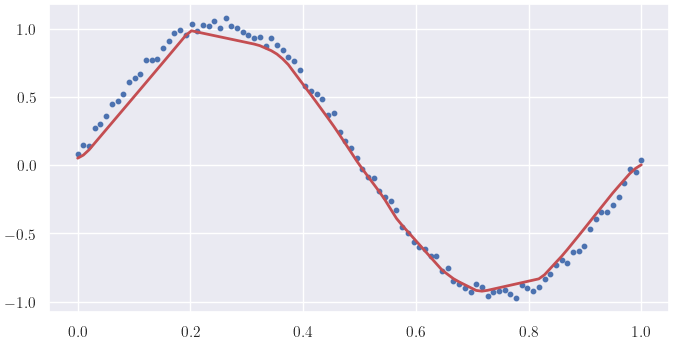

In [441]:
predicts = net(X)

_, ax = plt.subplots(1)
ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

4.2 Предсказание цен алмазов

4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

4.3 Модифицируйте метод `__init__` датасета из 4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        # ....
        self.transform = transform
        # ....

    def __len__(self):
        pass

    def __getitem__(self, idx):
        # ...
        sample = self.X[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        # ....

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        pass

    def __call__(self, sample):
        X, y = sample
        # <удаление из X столбцов self.drop>
        return X, y

In [ ]:
class ToTensorTransform:
    def __call__(self, sample):
        X, y = sample
        # <преобразование X и y в тензоры>
        return X, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(data, transforms.compose([drop, to_tensor]))
